# Methods for finding the scaling factor

This notebook compares different methods of finding the scaling factor to be applied to the single-dish data. uv-samples where the interometer-ed image and single-dish image overlap are compared.

In [3]:
# ipython notebook setup:
%matplotlib inline

In [4]:
import pylab as pl
pl.rcParams['image.interpolation'] = 'nearest'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (12,8)
pl.rcParams['image.cmap'] = 'viridis'
pl.rcParams['patch.edgecolor'] = 'none'
pl.rcParams['axes.prop_cycle'] = pl.cycler('color', ('#338ADD', '#9A44B6', '#A60628', '#467821', '#CF4457', '#188487', '#E24A33'))

In [5]:
import image_registration
from astropy import convolution
import numpy as np
from uvcombine.uvcombine import feather_compare
from uvcombine.scale_factor import find_effSDbeam
# from uvcombine.tests.utils import generate_test_fits
from astropy.utils.console import ProgressBar

In [6]:
# create an input image with specified parameters
# (this can later be modified - it will be good to examine the effects of
# different power laws, different types of input...)
# We're assuming a scale of 1"/pixel for this example
np.random.seed(0)
imsize = 1024
im = image_registration.tests.make_extended(imsize=imsize, powerlaw=1.5)

In [7]:
ygrid, xgrid = np.indices(im.shape, dtype='float')
rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5

In [8]:
# Create a UV sampling mask.
# This removes all large-angular scale (r<8) features *in UV space* and all
# small angular scales.
# In fourier space, r=0 corresponds to the DC component
# r=1 corresponds to the full map (one period over that map)
# r=256 is the smallest angular scale, which is 2 pixels (nyquist sampling....?)
# We're assuming a pixel scale of 1" / pixel
# therefore 56" corresponds to 9m at 2mm (i.e., nearly the closest spacing possible for 7m)
# We cut off the "interferometer" at 2.5" resolution
largest_scale = 56.
smallest_scale = 2.5
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

In [9]:
# create the interferometric map by removing both large and small angular
# scales in fourier space
imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)

In [10]:
# create the single-dish map by convolving the image with a FWHM=40" kernel
# (this interpretation is much easier than the sharp-edged stuff in fourier
# space because the kernel is created in real space)
lowresfwhm = 30
singledish_im = convolution.convolve_fft(im,
                                         convolution.Gaussian2DKernel(lowresfwhm/2.35),
                                         boundary='fill', fill_value=im.mean())

In [11]:
# make some headers for HDUs
pixel_scale = 1 * u.arcsec
beamfwhm = lowresfwhm * u.arcsec
restfreq = (2 * u.mm).to(u.Hz, u.spectral())
header = {'CDELT1': -(pixel_scale).to(u.deg).value,
              'CDELT2': (pixel_scale).to(u.deg).value,
              'BMAJ': beamfwhm.to(u.deg).value,
              'BMIN': beamfwhm.to(u.deg).value,
              'BPA': 0.0,
              'CRPIX1': imsize/2.,
              'CRPIX2': imsize/2.,
              'CRVAL1': 0.0,
              'CRVAL2': 0.0,
              'CTYPE1': 'GLON-CAR',
              'CTYPE2': 'GLAT-CAR',
              'CUNIT1': 'deg',
              'CUNIT2': 'deg',
              'CRVAL3': restfreq.to(u.Hz).value,
              'CUNIT3': 'Hz',
              'CDELT3': 1e6, # 1 MHz; doesn't matter
              'CRPIX3': 1,
              'CTYPE3': 'FREQ',
              'RESTFRQ': restfreq.to(u.Hz).value,
              'BUNIT': 'MJy/sr',
             }
header = fits.Header(header)

interf_header = header.copy()
interf_fwhm = smallest_scale * u.arcsec
interf_header["BMAJ"] = interf_fwhm.to(u.deg).value
interf_header["BMIN"] = interf_fwhm.to(u.deg).value

Check the effects of assuming the wrong single-dish FWHM when calculating the scale factor. From [](), the ratios will have a quadratic dependence of the wavenumber when the wrong FWHM is used.

In [12]:
interferometer_hdu = fits.PrimaryHDU(im_interferometered.real, header=interf_header)
singledish_hdu = fits.PrimaryHDU(singledish_im, header=header)

# Sample a large range of FWHMs
lowresfwhms = np.arange(18, 46, 0.25) * u.arcsec

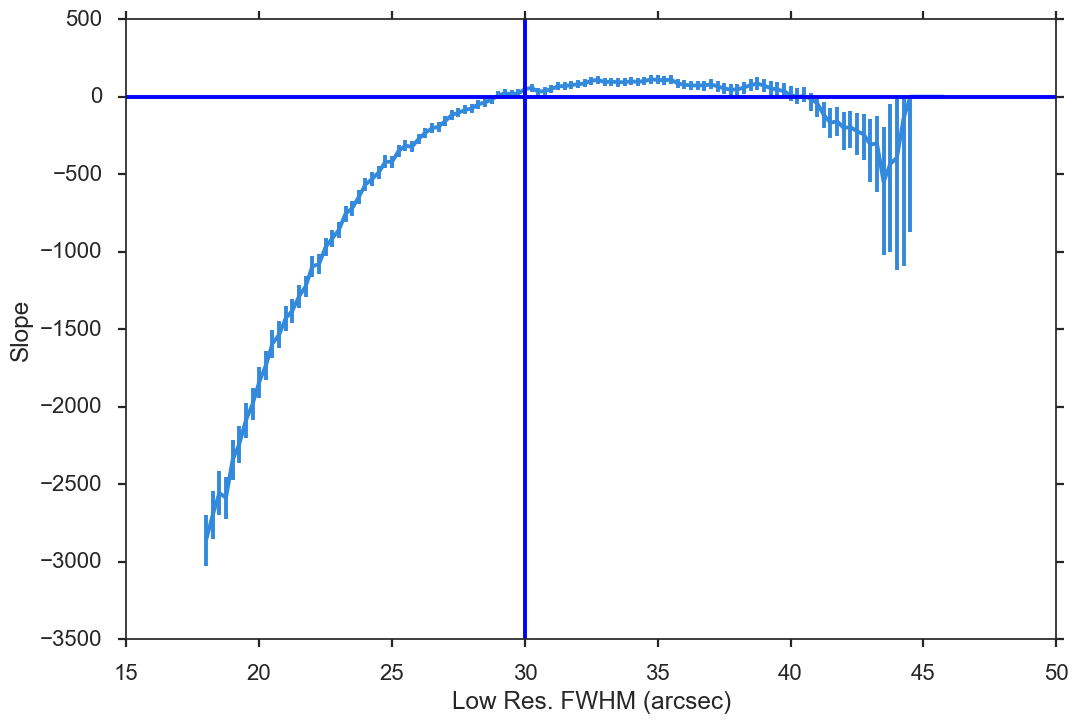

In [13]:
slopes, slopes_CI = \
    find_effSDbeam(interferometer_hdu, singledish_hdu, largest_scale * u.arcsec, lowresfwhms,
                   verbose=True)
pl.axvline(30)

The behaviour is close to quadratic, as expected. The approximation breaks down above the actual FWHM. The curve flattens out in this regime, so overestimating the FWHM is equally as bad for a large range.

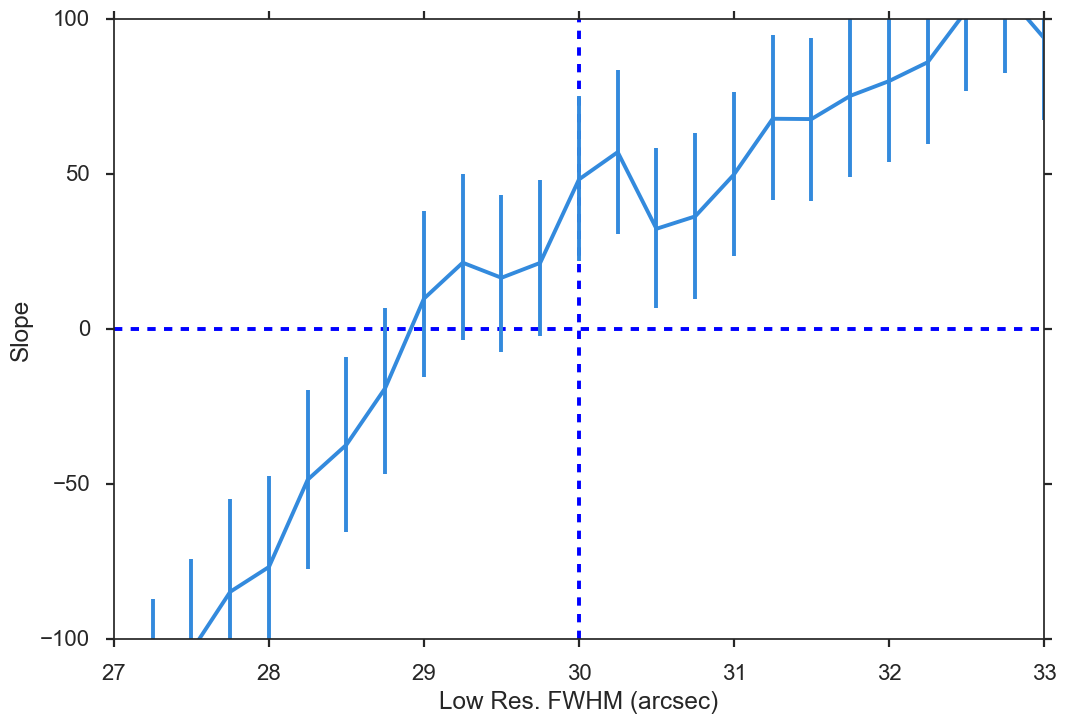

In [14]:
pl.errorbar(lowresfwhms.to(u.arcsec).value, slopes,
            yerr=[slopes - slopes_CI[0],
                  slopes_CI[1] - slopes])

pl.ylabel("Slope")
pl.xlabel("Low Res. FWHM (arcsec)")
pl.xlim([27, 33])
pl.ylim([-100, 100])
pl.axvline(30, linestyle='--', zorder=-1)
pl.axhline(0, linestyle='--', zorder=-1)

The slope is consistent with 0 at a FWHM just below the actual FWHM.

In [15]:
from scipy import interpolate

yToFind = 0
yreduced = slopes - yToFind
freduced = interpolate.UnivariateSpline(lowresfwhms.value, yreduced, s=1e5)
freduced.roots()

array([ 29.05970878,  40.13257091,  44.85118811,  45.6337948 ])

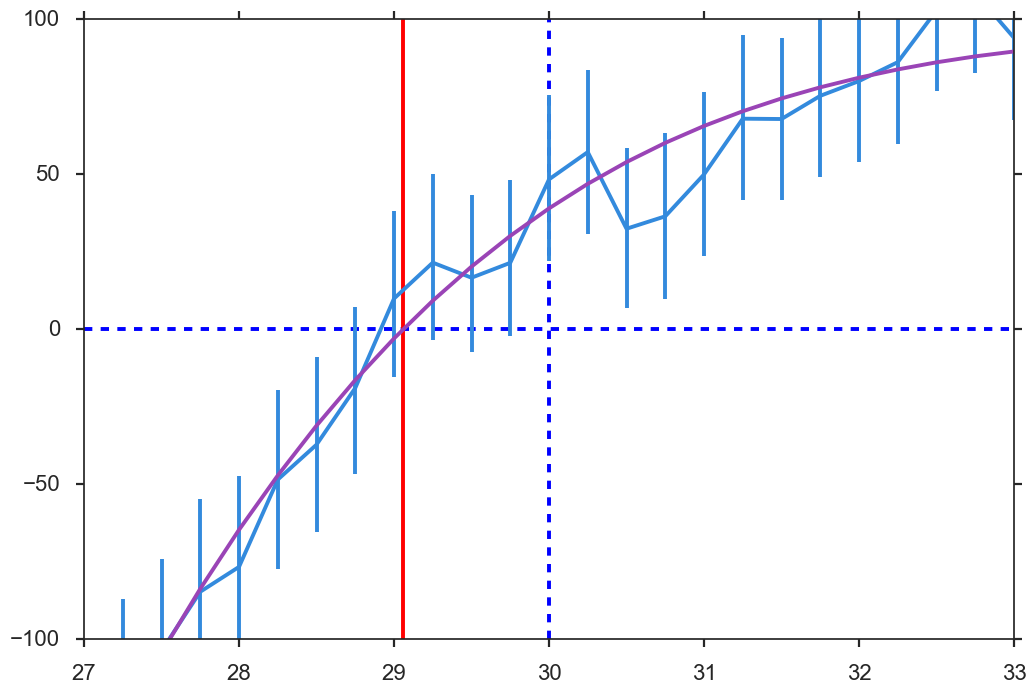

In [16]:
pl.errorbar(lowresfwhms.to(u.arcsec).value, slopes,
            yerr=[slopes - slopes_CI[0],
                  slopes_CI[1] - slopes])
pl.plot(lowresfwhms.value, freduced(lowresfwhms.value))
pl.xlim([27, 33])
pl.ylim([-100, 100])
pl.axvline(30, linestyle='--', zorder=-1)
pl.axhline(0, linestyle='--', zorder=-1)
# Closest spline root to the FWHM
pl.axvline(freduced.roots()[0], linestyle="-", color='r', zorder=-1)

This method returns a good approximation to the true FWHM, provoded you have a well-defined range where you already know where to look.

What is the behaviour of this method? Does it consistently under-estimate the true SD beam? Let's test via Monte Carlo.

In [17]:
def test_effSDbeam_find(niters=100, imsize=1024, powerlaw=1.5, lowresfwhm=30 * u.arcsec, interf_las=56 * u.arcsec,
                        interf_sas=2.5 * u.arcsec, pixel_scale=1 * u.arcsec,
                        test_range=np.arange(18, 46, 0.5) * u.arcsec,
                        wavelength=2 * u.mm):
    
    found_sdbeam = np.empty((niters))
    
    for i in ProgressBar(niters):
    
        im = image_registration.tests.make_extended(imsize=imsize, powerlaw=powerlaw)
        ygrid, xgrid = np.indices(im.shape, dtype='float')
        rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5
        image_scale = im.shape[0] # assume symmetric (default=256)
        ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))
    
        imfft = np.fft.fft2(im)
        imfft_interferometered = imfft * np.fft.fftshift(ring)
        im_interferometered = np.fft.ifft2(imfft_interferometered)
    
        singledish_im = convolution.convolve_fft(im,
                                                 convolution.Gaussian2DKernel(lowresfwhm.value / np.sqrt(8 * np.log(2))),
                                                 boundary='fill', fill_value=im.mean())
    
        beamfwhm = lowresfwhm
        restfreq = wavelength.to(u.Hz, u.spectral())
        header = {'CDELT1': -(pixel_scale).to(u.deg).value,
                  'CDELT2': (pixel_scale).to(u.deg).value,
                  'BMAJ': beamfwhm.to(u.deg).value,
                  'BMIN': beamfwhm.to(u.deg).value,
                  'BPA': 0.0,
                  'CRPIX1': imsize/2.,
                  'CRPIX2': imsize/2.,
                  'CRVAL1': 0.0,
                  'CRVAL2': 0.0,
                  'CTYPE1': 'GLON-CAR',
                  'CTYPE2': 'GLAT-CAR',
                  'CUNIT1': 'deg',
                  'CUNIT2': 'deg',
                  'CRVAL3': restfreq.value,
                  'CUNIT3': 'Hz',
                  'CDELT3': 1e6, # 1 MHz; doesn't matter
                  'CRPIX3': 1,
                  'CTYPE3': 'FREQ',
                  'RESTFRQ': restfreq.to(u.Hz).value,
                  'BUNIT': 'MJy/sr',
                 }
        header = fits.Header(header)

        interf_header = header.copy()
        interf_fwhm = interf_sas
        interf_header["BMAJ"] = interf_fwhm.to(u.deg).value
        interf_header["BMIN"] = interf_fwhm.to(u.deg).value
    
        interferometer_hdu = fits.PrimaryHDU(im_interferometered.real, header=interf_header)
        singledish_hdu = fits.PrimaryHDU(singledish_im, header=header)
    
        slopes, slopes_CI = \
            find_effSDbeam(interferometer_hdu, singledish_hdu, interf_las, test_range,
                           verbose=False)
    
        yToFind = 0
        yreduced = slopes - yToFind
        freduced = interpolate.UnivariateSpline(test_range.value, yreduced, s=1e5)
        closest_fwhm = freduced.roots()[np.argmin(np.abs(freduced.roots() - lowresfwhm.value))]
        
        found_sdbeam[i] = closest_fwhm
        
    return found_sdbeam * test_range.unit

In [35]:
mc_effSDbeams = test_effSDbeam_find(niters=100, test_range=np.arange(18, 46, 0.5) * u.arcsec)

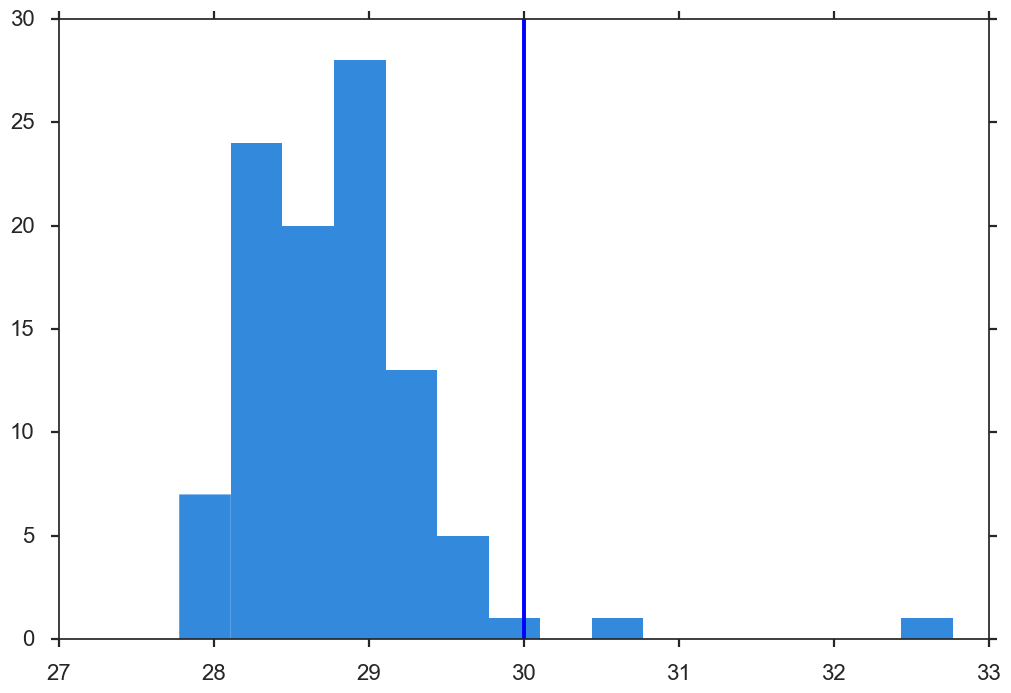

In [40]:
_ = pl.hist(mc_effSDbeams.value, bins=15)
pl.axvline(30)

# Determining the scale factor

With a single plane, and limited uv-overlap, the number of samples to derive the scale factor is quite limited. If instead we have a spectral-line data cube, the samples may be combined to examine their distribution. This assumes that the noise is roughly constant in the different channels.

With simulated data, what does the distribution of the ratios in the overlap region look like?

In [69]:
nplanes = 100
ratios = []
highres_pts = []
lowres_pts = []
wavelength = 2 * u.mm

for _ in ProgressBar(nplanes):
        im = image_registration.tests.make_extended(imsize=imsize, powerlaw=1.5)
        # Let's add a bit of noise
        im += np.random.normal(0, 0.8, size=im.shape)
        ygrid, xgrid = np.indices(im.shape, dtype='float')
        rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5
        image_scale = im.shape[0] # assume symmetric (default=256)
        ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))
    
        imfft = np.fft.fft2(im)
        imfft_interferometered = imfft * np.fft.fftshift(ring)
        im_interferometered = np.fft.ifft2(imfft_interferometered)
    
        singledish_im = convolution.convolve_fft(im,
                                                 convolution.Gaussian2DKernel(lowresfwhm / np.sqrt(8 * np.log(2))),
                                                 boundary='fill', fill_value=im.mean())
    
        beamfwhm = lowresfwhm * u.arcsec
        restfreq = wavelength.to(u.Hz, u.spectral())
        header = {'CDELT1': -(pixel_scale).to(u.deg).value,
                  'CDELT2': (pixel_scale).to(u.deg).value,
                  'BMAJ': beamfwhm.to(u.deg).value,
                  'BMIN': beamfwhm.to(u.deg).value,
                  'BPA': 0.0,
                  'CRPIX1': imsize/2.,
                  'CRPIX2': imsize/2.,
                  'CRVAL1': 0.0,
                  'CRVAL2': 0.0,
                  'CTYPE1': 'GLON-CAR',
                  'CTYPE2': 'GLAT-CAR',
                  'CUNIT1': 'deg',
                  'CUNIT2': 'deg',
                  'CRVAL3': restfreq.value,
                  'CUNIT3': 'Hz',
                  'CDELT3': 1e6, # 1 MHz; doesn't matter
                  'CRPIX3': 1,
                  'CTYPE3': 'FREQ',
                  'RESTFRQ': restfreq.to(u.Hz).value,
                  'BUNIT': 'MJy/sr',
                 }
        header = fits.Header(header)

        interf_header = header.copy()
        interf_fwhm = smallest_scale * u.arcsec
        interf_header["BMAJ"] = interf_fwhm.to(u.deg).value
        interf_header["BMIN"] = interf_fwhm.to(u.deg).value
    
        interferometer_hdu = fits.PrimaryHDU(im_interferometered.real, header=interf_header)
        singledish_hdu = fits.PrimaryHDU(singledish_im, header=header)
        
        plane_samples = feather_compare(interferometer_hdu, singledish_hdu, SAS=lowresfwhm * u.arcsec,
                                        LAS=largest_scale * u.arcsec, lowresfwhm=lowresfwhm * u.arcsec,
                                        return_samples=True, doplot=False)
        ratios.append(plane_samples[1])
        highres_pts.append(plane_samples[2])
        lowres_pts.append(plane_samples[3])
        
ratios = np.hstack(ratios)
highres_pts = np.hstack(highres_pts)
lowres_pts = np.hstack(lowres_pts)

In [70]:
# There's some sort of numerical effect going on in the interferometer image. Remove the low outliers at the
# float precision level
good_pts = np.where(np.log(highres_pts) > -20)

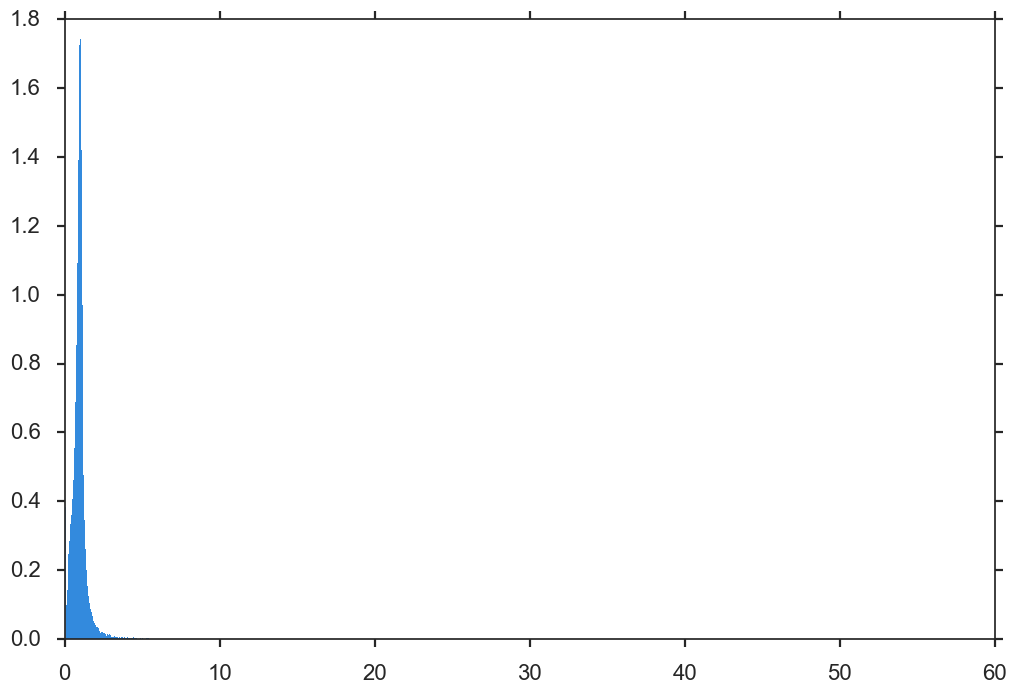

In [61]:
from astropy.visualization import hist
_ = hist(ratios, bins='scott', normed=True)

The ratios have a strong tail. In log-space, the low-end tail is actually more prominent than the upper. This must have to do with the power-law nature of the original image.

The following analysis treats these tails as symmetric. The ratios from observational data appear to have more symmetric tails than are shown here.

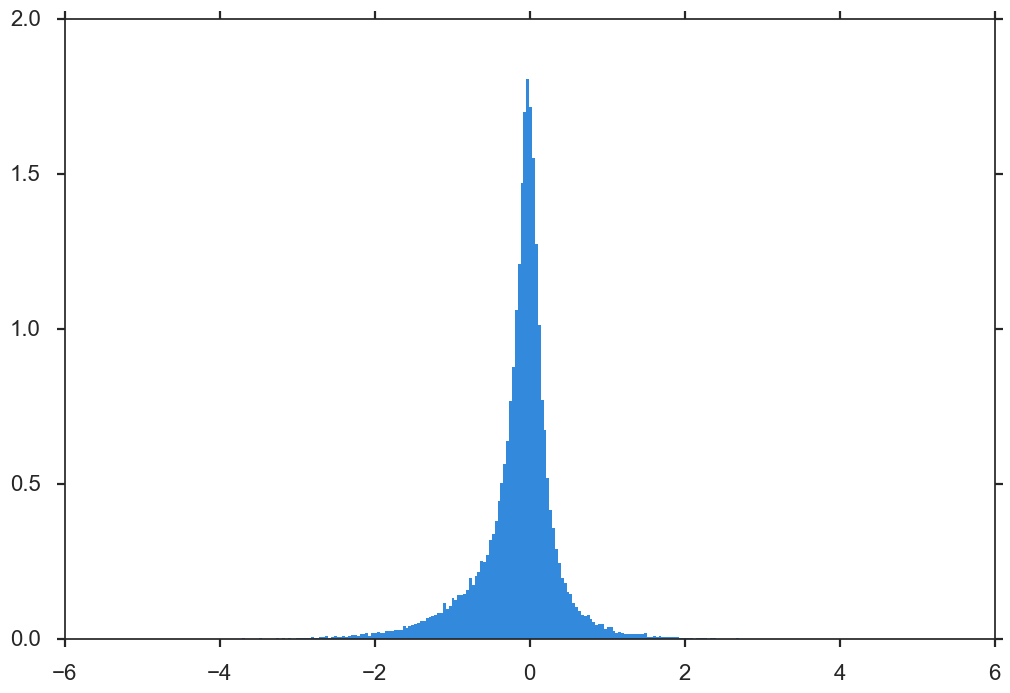

In [68]:
_ = hist(np.log(ratios[good_pts]), bins='scott', normed=True)

This results from highres_pts and lowres_pts being close to log-normally distributed. For the power-law image, the bottom tail is heavier than the other.

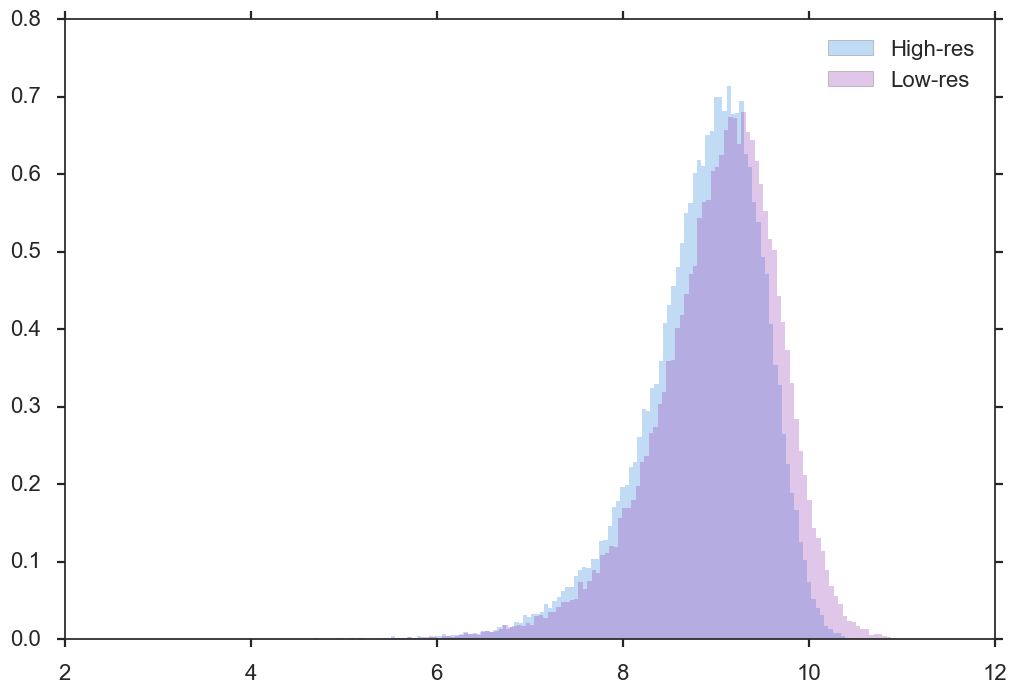

In [63]:
_ = hist(np.log(highres_pts[good_pts]), bins='scott', normed=True, alpha=0.3, label="High-res")
_ = hist(np.log(lowres_pts), bins='scott', normed=True, alpha=0.3, label="Low-res")
p.legend()

It would be more appropriate to treat each distribution as a power-law log-normal distribution. For the purposes of showing how to get the scale factor, assume these are log-normal variates.

The ratio of two log-normally distributed variables is a Cauchy distribution in log-space. Thus to find the scaling factor, the log of the ratio is fit to a Cauchy distribution. Its median is then an estimate of the scaling factor.

In [64]:
import scipy.stats
cauchy_fit = stats.cauchy.fit(np.log(ratios[good_pts]))
print(cauchy_fit)
print(np.exp(np.array(cauchy_fit)))

(-0.049937821197727605, 0.17835754659963782)
[ 0.95128857  1.1952526 ]


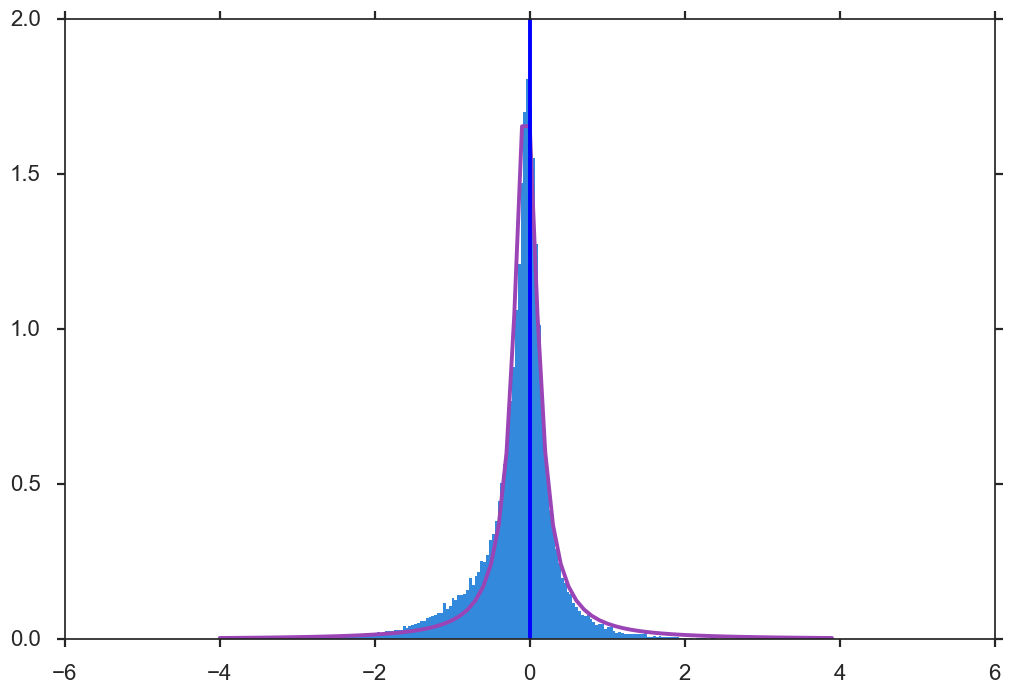

In [66]:
_ = hist(np.log(ratios[good_pts]), bins='scott', normed=True)
pl.plot(np.arange(-4, 4, 0.1), stats.cauchy.pdf(np.arange(-4, 4, 0.1), *cauchy_fit))
pl.axvline(np.log(1))

The scaling factor is below 1, as expected due to the heavier tail at low values.

The scipy method gives no estimate of uncertainties. Adopting a likelihood model with statsmodels provides an estimate of the parameter uncertainties *assuming normality*.

In [136]:
try:
    from statsmodels.base.model import GenericLikelihoodModel
except ImportError:
    raise ImportError("statsmodels must be installed to run this cell.")

class Likelihood(GenericLikelihoodModel):

    # Get the number of parameters from shapes.
    # Add one for scales, since we're assuming loc is frozen.
    # Keeping loc=0 is appropriate for log-normal models.
    nparams = 1 if stats.cauchy.shapes is None else \
        len(stats.cauchy.shapes.split(",")) + 1

    def loglike(self, params):
        if np.isnan(params).any():
            return - np.inf

        loglikes = \
            stats.cauchy.logpdf(self.endog, *params[:-2],
                                scale=params[-1],
                                loc=params[-2])
        if not np.isfinite(loglikes).all():
            return - np.inf
        else:
            return loglikes.sum()

In [140]:
mle_model = Likelihood(np.log(ratios))
fitted_model = mle_model.fit(cauchy_fit, method='nm')
fitted_model.df_model = len(ratios)
fitted_model.df_resid = len(ratios) - 2

Optimization terminated successfully.
         Current function value: 0.822394
         Iterations: 15
         Function evaluations: 30


In [153]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Likelihood Results                              
==============================================================================
Dep. Variable:                      y   Log-Likelihood:            -1.0831e+05
Model:                     Likelihood   AIC:                         4.800e+05
Method:            Maximum Likelihood   BIC:                         1.769e+06
Date:                Wed, 07 Jun 2017                                         
Time:                        13:42:11                                         
No. Observations:              131700                                         
Df Residuals:                  131698                                         
Df Model:                      131700                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
par0          -0.0522      0.001    -70.423      0.000        -0.054    -0.051
par1           0.1884      0.001    256.358      0.000         0.187     0.190
==============================================================================
"""

In [154]:
print("Scale factor: {0}+/-{1}".format(np.exp(fitted_model.params[0]),
                                       np.abs(fitted_model.bse[0] / fitted_model.params[0])))

Scale factor: 0.949096632288+/-0.0141998627835
